In [2]:
using Plots
using Flux
using DiffEqFlux
using OrdinaryDiffEq

 45.526759 seconds (104.05 M allocations: 6.677 GiB, 3.73% gc time, 99.29% compilation time)


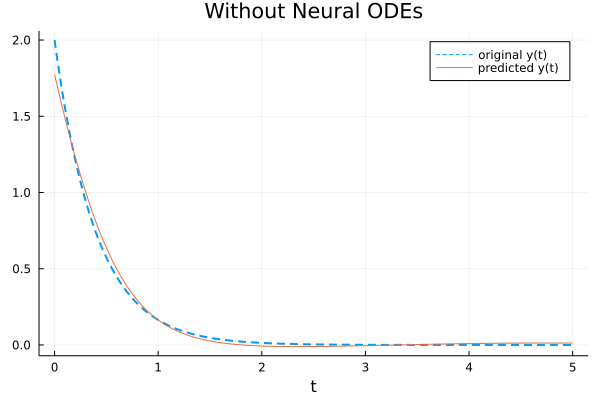

In [3]:
t0 = 0.0
tend = 5.0
N = 200
true_x = range(t0, tend, length=N+1)
true_y = 2*exp.(-true_x./0.4)

function neural_network(data_dim)
    fc = FastChain(FastDense(data_dim, 64, swish),
                  FastDense(64, 32, swish),
                  FastDense(32, data_dim))
end

nn = neural_network(1)
theta = initial_params(nn)

predict(t, p) = nn(t', p)'

loss(p) = begin
  yhat = predict(true_x, p)
  l = Flux.mse(yhat, true_y)
end

learning_rate=1e-2
opt = ADAMW(learning_rate)
epochs = 100

loss_array = []

function cb_train(theta, loss)
    #println("Loss: ", loss)
    append!(loss_array, loss)
    false
end

@time res_train = DiffEqFlux.sciml_train(
    loss, theta, opt,
    maxiters = epochs,
    cb = cb_train)

predicted_y = predict(true_x, res_train.minimizer)

plot(
    true_x,
    true_y,
    linewidth=2, ls=:dash,
    title="Without Neural ODEs",
    xaxis="t",
    label="original y(t)",
    legend=:topright)

plot!(
    true_x,
    predicted_y,
    linewidth=1,
    label="predicted y(t)")

In [4]:
t0 = 0.0
tend = 5.0
N = 200
true_x = range(t0, tend, length=N+1)
true_y = 2*exp.(-true_x./0.4)

function neural_ode(data_dim; saveat = true_x)
    fc = FastChain(FastDense(data_dim, 64, swish),
                  FastDense(64, 32, swish),
                  FastDense(32, data_dim))

    n_ode = NeuralODE(
            fc,
            (minimum(true_x), maximum(true_x)),
            Tsit5(),
            saveat = saveat,
            abstol = 1e-2, reltol = 1e-2)
end

n_ode = neural_ode(1)
theta = n_ode.p

predict(p) = n_ode(true_y[1:1], p)'

loss(p) = begin
  yhat = predict(p)
  l = Flux.mse(yhat, true_y)
end

learning_rate=1e-2
opt = BFGS()
#epochs = 200

loss_array2 = []

function cb_train(theta, loss)
    #println("Loss: ", loss)
    append!(loss_array2, loss)
    false
end

@time res_train = DiffEqFlux.sciml_train(
    loss, theta, opt,
    maxiters = epochs,
    cb = cb_train)

predicted_y = predict(res_train.minimizer)

plot(
    true_x,
    true_y,
    linewidth=2, ls=:dash,
    title="With Neural ODEs",
    xaxis="t",
    label="original y(t)",
    legend=:topright)

plot!(
    true_x,
    true_y,
    linewidth=1,
    label="predicted y(t)")

┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\25674\.julia\packages\SciMLBase\7GnZA\src\integrator_interface.jl:351
┌ Warning: First function call produced NaNs. Exiting.
└ @ OrdinaryDiffEq C:\Users\25674\.julia\packages\OrdinaryDiffEq\6gTvi\src\initdt.jl:121
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\25674\.julia\packages\SciMLBase\7GnZA\src\integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\25674\.julia\packages\SciMLBase\7GnZA\src\integrator_interface.jl:351
┌ Warning: Size mismatch in loss function! In future this will be an error. In Flux <= 0.12 broadcasting accepts this, but may not give sensible results
│   summary(ŷ) = 19×1 adjoint(::ODESolution{Float64, 2, Vector{Vector{Float64}}, Nothing, Nothing, Vector{Float64}, Vector{Vector{Vector{Float64}}}, ODEProblem{Vector{Float64}, Tuple{Float64, Float64}, false, Vector{Float32}, ODEFunction{false, DiffEqFlux.var"#dudt_#109"{NeuralODE{FastChain{Tuple{

LoadError: DimensionMismatch("arrays could not be broadcast to a common size; got a dimension with lengths 19 and 201")

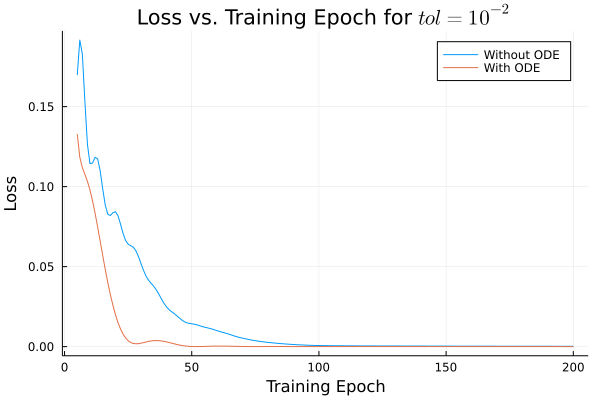

In [56]:
using LaTeXStrings
epoch_list = 5:1:epochs
plot(epoch_list, loss_array[6:end],
    label = "Without ODE",
    xaxis = "Training Epoch",
    yaxis = "Loss",
    title = "Loss vs. Training Epoch for " * L"tol=10^{-2}",
    legend =:topright)
plot!(epoch_list, loss_array2[6:end],
    label = "With ODE")

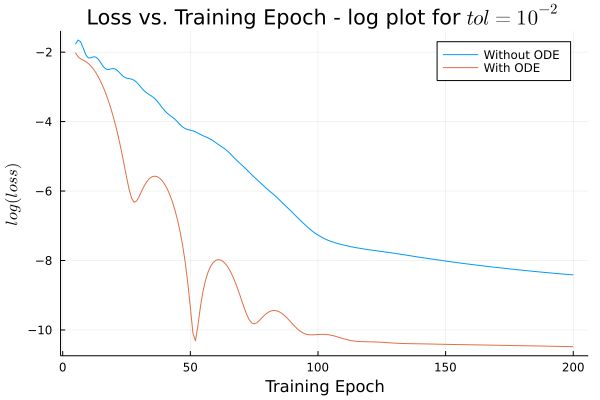

In [57]:
plot(epoch_list, log.(loss_array[6:end]),
    label = "Without ODE",
    xaxis = "Training Epoch",
    yaxis = L"log(loss)",
    title = "Loss vs. Training Epoch - log plot for " * L"tol = 10^{-2}",
    legend =:topright)
plot!(epoch_list, log.(loss_array2[6:end]),
    label = "With ODE")